# Airbnb Scraper

In [2]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from selenium.webdriver.chrome.service import Service
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selectorlib import Extractor
import time

chromedrive_path = os.path.join(os.getcwd(),"chromedriver") # use the path to the driver you downloaded from previous steps
chrome_executable = Service(executable_path=chromedrive_path , log_path='NUL')
driver = webdriver.Chrome(service=chrome_executable)

URLs to be scraped containing the results of the AirBnB search

In [3]:
url_list = [
    'https://www.airbnb.it/s/Bonassola--SP/homes?tab_id=home_tab&refinement_paths%5B%5D=%2Fhomes&flexible_trip_lengths%5B%5D=one_week&price_filter_input_type=0&query=Bonassola%2C%20SP&place_id=ChIJycPVhgHt1BIRBQdfBAmgGv0&date_picker_type=calendar&source=structured_search_input_header&search_type=autocomplete_click',
    'https://www.airbnb.it/s/Bonassola--SP/homes?tab_id=home_tab&refinement_paths%5B%5D=%2Fhomes&flexible_trip_lengths%5B%5D=one_week&price_filter_input_type=0&query=Bonassola%2C%20SP&place_id=ChIJycPVhgHt1BIRBQdfBAmgGv0&date_picker_type=calendar&source=structured_search_input_header&search_type=autocomplete_click&federated_search_session_id=e774e55e-5532-4082-b425-2afd3ebcfb58&pagination_search=true&items_offset=20&section_offset=2',
    'https://www.airbnb.it/s/Bonassola--SP/homes?tab_id=home_tab&refinement_paths%5B%5D=%2Fhomes&flexible_trip_lengths%5B%5D=one_week&price_filter_input_type=0&query=Bonassola%2C%20SP&place_id=ChIJycPVhgHt1BIRBQdfBAmgGv0&date_picker_type=calendar&source=structured_search_input_header&search_type=autocomplete_click&federated_search_session_id=e774e55e-5532-4082-b425-2afd3ebcfb58&pagination_search=true&items_offset=40&section_offset=2',
    'https://www.airbnb.it/s/Bonassola--SP/homes?tab_id=home_tab&refinement_paths%5B%5D=%2Fhomes&flexible_trip_lengths%5B%5D=one_week&price_filter_input_type=0&query=Bonassola%2C%20SP&place_id=ChIJycPVhgHt1BIRBQdfBAmgGv0&date_picker_type=calendar&source=structured_search_input_header&search_type=autocomplete_click&federated_search_session_id=e774e55e-5532-4082-b425-2afd3ebcfb58&pagination_search=true&items_offset=60&section_offset=2',
]

Main features to be scraped:

 - url home
 - id home
 - maximum number of guests
 - number of beds
 - numbers of bathrooms
 - number of rooms
 - number of reviews
 - rating
 - position
 - price

In [4]:
def id_house(s):
    s = s.split('?')
    s = s[0]
    s = s.replace(r'https://www.airbnb.it/rooms/','')
    return s

def url_house(u):
    u = 'https://www.airbnb.it'+u
    return u

def get_info_house(url):
    
    page_house = requests.get(url)
    soup_house = BeautifulSoup(page_house.content, features="lxml")
    
    list_house_1 = soup_house.findAll('li', {'class': 'l7n4lsf dir dir-ltr'})
    
    name = soup_house.find('h1', {'class': '_fecoyn4'}).text
    max_guests = list_house_1[0].text
    bedrooms = list_house_1[1].text
    beds = list_house_1[2].text
    bathrooms = list_house_1[3].text
    
    try:
        reviews = soup_house.find('span', {'class': '_1y9gwt75'}).text
    except:
        reviews = np.nan
    
    return name, max_guests, bedrooms, beds, bathrooms, reviews

def extract_location(url):
    url = url.split('=')
    url = url[1].split(',')
    y = float(url[0])
    x = float(url[1].replace('&z',''))
    
    return x,y

def house_location(url_house):
    
    driver.get(url_house)
    time.sleep(1)
    driver.execute_script("window.scrollTo(0, 3500)")
    time.sleep(1)
    
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    try:
        url = soup.find('a',{'title':'Visualizza questa zona in Google Maps (in una nuova finestra)'}).get('href')
        x,y = extract_location(url)
    except:
        x,y = np.nan,np.nan
    
    return x,y

dict_out = {}

for url in url_list:
    
    page = requests.get(url)
    soup = BeautifulSoup(page.content, features="lxml")
    
    p_list = soup.findAll('div', {'class': "_1jo4hgw"})
    id_list = soup.findAll('a', {'class': 'ln2bl2p dir dir-ltr'})
    
    for i,price in zip(id_list,p_list):

        url_h = url_house(str(i['href']))
        id_ = id_house(url_h)
        price = price.text
        
        name, max_guests, bedrooms, beds, bathrooms, reviews = get_info_house(url_h)
        x,y = house_location(url_h)
        
        dict_out[id_] = {
            'name':name,
            'url':url_h,
            'bedrooms':bedrooms,
            'beds':beds,
            'bathrooms':bathrooms,
            'reviews':reviews,
            'price':price,
            'x':x,
            'y':y
                        }

Clean the data and create a dataframe with the information

In [5]:
def get_number(s):
    for j in s:
        if j.isdigit()==True:
            return int(j)

df = pd.DataFrame(dict_out)
df = df.T
for c in ['bedrooms','beds','bathrooms']:
    df[c] = [get_number(i) for i in df[c]]

rating = []
reviews = []

for i in df['reviews']:
    
    ra = ''
    re = ''
    
    try:
        i = i.split(' ')
        ra = float(i[0])
        re = i[1]
        re = float(''.join(s for s in re if s.isdigit()))
    except:
        ra,re, = np.nan,np.nan

    rating.append(ra)
    reviews.append(re)

df['reviews'] = reviews
df['rating'] = rating

price = []

for p in df['price']:
    p = p.split('€')
    p = float(p[0])
    price.append(p)

df['price'] = price    
df.to_csv('listing.csv')
display(df)

,name,url,bedrooms,beds,bathrooms,reviews,price,x,y,rating
16938574,tipico monolocale marinaro Riviera Ligure,https://www.airbnb.it/rooms/16938574?adults=1&...,1.0,2,1,125.0,88.0,NaN,NaN,4.80
713387525175092014,Casa MIA con splendida vista mare e giardino.,https://www.airbnb.it/rooms/713387525175092014...,2.0,2,2,NaN,75.0,NaN,NaN,NaN
41277463,Paradiso a Bonassola vicino alle Cinqueterre,https://www.airbnb.it/rooms/41277463?adults=1&...,3.0,4,2,18.0,111.0,9.5839,44.18318,4.44
5120219,Soggiorno in scogliera a Bonassola,https://www.airbnb.it/rooms/5120219?adults=1&c...,1.0,2,1,45.0,152.0,9.57355,44.18224,4.76
10464653,2 camere e cucina a 2 passi dal mar,https://www.airbnb.it/rooms/10464653?adults=1&...,2.0,4,1,62.0,84.0,9.58369,44.18371,4.40
...,...,...,...,...,...,...,...,...,...,...
25026474,Luminoso appartamento frontemare a Deiva Marina,https://www.airbnb.it/rooms/25026474?adults=1&...,2.0,4,1,56.0,82.0,9.51347,44.21533,4.80
51036898,Spartan Yet Comfortable Apt With Stunning View,https://www.airbnb.it/rooms/51036898?adults=1&...,2.0,3,2,28.0,138.0,9.5875,44.18625,4.89
44694694,"Le Lagore, esperienza di Glamping Tent&Stable",https://www.airbnb.it/rooms/44694694?adults=1&...,2.0,1,1,68.0,310.0,9.59636,44.17754,4.97
3323427,Framura: villa nel verde,https://www.airbnb.it/rooms/3323427?adults=1&c...,NaN,2,1,40.0,71.0,9.56392,44.20649,4.68


Preliminary data exploration

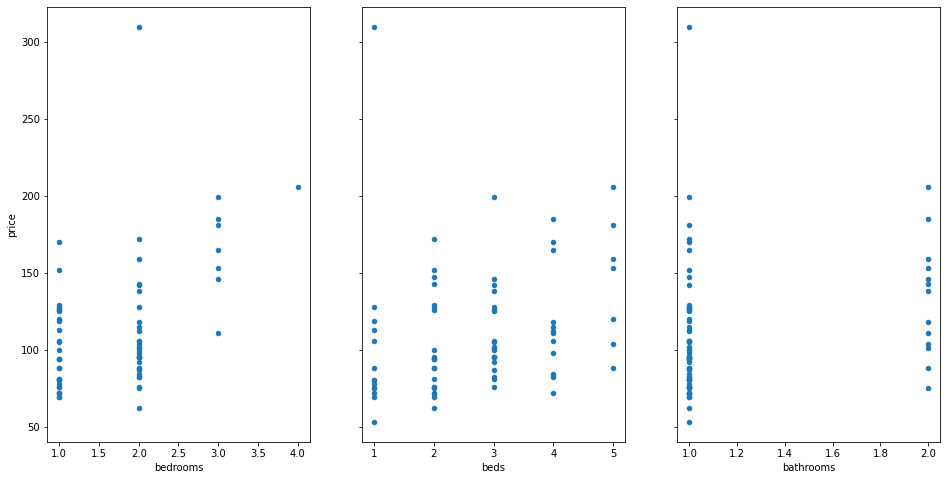

In [6]:
fig, ax = plt.subplots(1,3, figsize=(16,8),sharey = True)
for a,c in zip(ax,['bedrooms','beds','bathrooms']):
    df.plot.scatter(x = c,y = 'price',ax = a)
plt.show()

#### Reviews

In [7]:
def get_reviews(url):
    
    driver.get(url)
    
    wait = WebDriverWait(driver,10)
    
    x_path_easy = "//div[@data-testid='pdp-reviews-modal-scrollable-panel']//div[@class='r1are2x1 dir dir-ltr']"
    x_path_easy_2 = "(//div[@data-testid='pdp-reviews-modal-scrollable-panel']//div[@class='r1are2x1 dir dir-ltr'])[last()]"
    try:
        wait.until(EC.presence_of_all_elements_located((By.XPATH,x_path_easy)))
        n = 0 
        i = 0
        while True:

            n_1 = n
            driver.find_element(By.XPATH,x_path_easy_2).location_once_scrolled_into_view
            n = len(driver.find_elements(By.XPATH,x_path_easy))
            if n_1 == n:
                i+=1
            else:
                i = 0

            if i>30:
                break


        soup_reviews = BeautifulSoup(driver.page_source, features="lxml")
        r_list = soup_reviews.findAll('div', {'class': "r1are2x1 dir dir-ltr"})

        return r_list
    except:
        return []

In [8]:
from datetime import datetime

months = ['gennaio','febbraio','marzo','aprile','maggio','giugno','luglio','agosto','settembre','ottobre','novembre','dicembre']
dict_month = {}
for n,m in enumerate(months):
    dict_month[m] = n+1

def edit_date(date):
    date = date.split(' ')
    year = date[1]
    month = dict_month[date[0]]
    date = year+'-'+str(month)

    return date

In [9]:
data = []

for i in df.index:
    
    #print(i)
    url = df.loc[i,'url']
    url_reviews = url.replace('?adults','/reviews?adults')
    
    all_rev = get_reviews(url_reviews)
    
    for r in all_rev:
        date = r.find('ol',{'class':'_7h1p0g'})
        date = edit_date(date.text)
        data.append([i,date])

In [10]:
df_r = pd.DataFrame(data=data,columns = ['id','date'])
df_r['date'] = pd.to_datetime(df_r['date'])
df_r.to_csv('reviews.csv')

In [11]:
display(df_r)

,id,date
0,16938574,2022-09-01
1,16938574,2022-08-01
2,16938574,2022-07-01
3,16938574,2022-07-01
4,16938574,2022-06-01
...,...,...
3513,49183951,2022-04-01
3514,49183951,2021-08-01
3515,49183951,2021-08-01
3516,49183951,2021-06-01


In [12]:
df_r_s = df_r['id'].value_counts().rename_axis('id').reset_index(name='frequency')
display(df_r_s)

,id,frequency
0,6043179,283
1,6042880,243
2,13913676,212
3,11763110,210
4,1648424,199
...,...,...
67,713387525175092014,2
68,32585681,2
69,627095585063611679,1
70,589770836982941169,1


In [13]:
df_r_t = df_r['date'].value_counts().rename_axis('date').reset_index(name='frequency')
df_r_t = df_r_t.sort_values(by=['date'])
print(type(df_r_t.date.dtypes))
display(df_r_t)

<class 'numpy.dtype[datetime64]'>


,date,frequency
95,2013-09-01,1
85,2013-10-01,3
91,2013-11-01,2
98,2014-01-01,1
86,2014-03-01,3
...,...,...
2,2022-05-01,109
0,2022-06-01,147
1,2022-07-01,115
3,2022-08-01,109


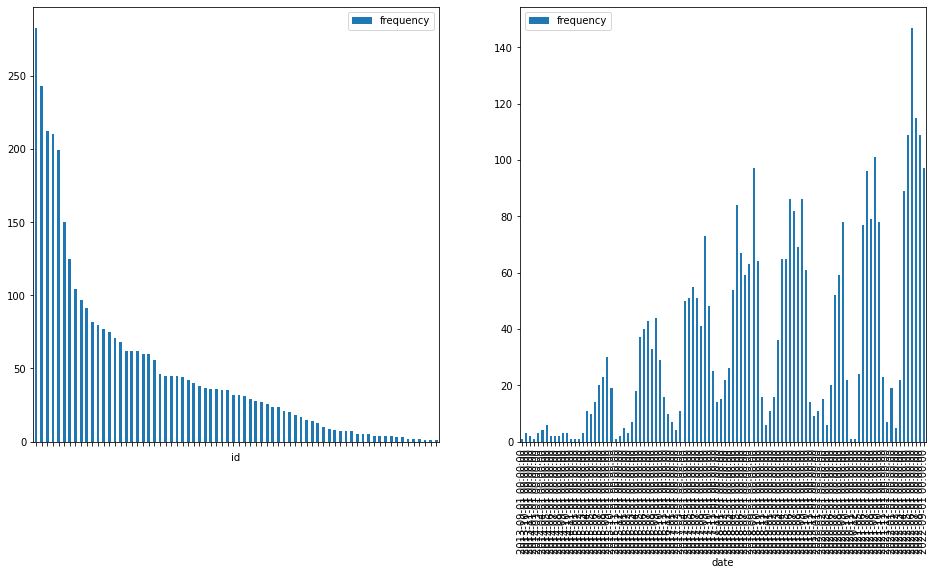

In [14]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
df_r_s.plot.bar(x='id',y='frequency',ax = ax[0])
df_r_t.plot.bar(x='date',y='frequency',ax = ax[1])
ax[0].set_xticklabels([])
#ax[1].set_xticklabels(np.linspace(df_r_t.date.min,df_r_t.date.max,20))
plt.show()